# Modeling Notebook

This notebook contains all EDA and modeling/regression work.

In [1]:
# Imports for dataframe
%pylab inline
import pandas as pd
import numpy as np

#Imports for statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

#Imports for plotting and sklearn linear regression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

# Imports for sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import the cleaned CSV file
df = pd.read_csv('steam_cleaned_dataframe.csv')

In [3]:
print(len(df))

19586


In [4]:
# Set criterion that a game must have 1 review/day over the lifespan of the game
df = df[df['Reviews_Per_Day'] > 1]

In [5]:
print(len(df))

2871


In [6]:
# Select the target variable [0] and features [1:]
df = df[['All_Perc_Review',
         'Reviews_Per_Day', 'Clean_Price',
         'Storage_MB', 'Recent_Num_Review',
         'Num_Genres', 'Is_It_Indie']]

In [7]:
df.describe()

,All_Perc_Review,Reviews_Per_Day,Clean_Price,Storage_MB,Recent_Num_Review,Num_Genres,Is_It_Indie
count,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000
mean,82.656217,15.105430,14.513243,8277.183560,398.546151,2.951933,0.622431
std,12.708549,64.021809,14.339173,13906.597119,2737.549076,1.477752,0.484863
min,18.000000,1.001019,0.000000,1.000000,10.000000,1.000000,0.000000
25%,77.000000,1.643317,0.000000,700.000000,26.500000,2.000000,0.000000
50%,86.000000,3.088517,13.990000,3000.000000,59.000000,3.000000,1.000000
75%,92.000000,7.640435,19.990000,10000.000000,172.500000,4.000000,1.000000
max,100.000000,1582.227083,59.990000,150000.000000,122787.000000,12.000000,1.000000


## EDA: Decide Which Features to Remove

Take a look at correlations with 'All_Perc_Review' (Overall User Rating).

There seems to be little to decipher from the pair plot. Heat map is a good indicator of which features are multicollinear.

Index from dataframe for features is:
* [1] Reviews_Per_Day
* [2] Clean_Price
* [3] Storage_MB
* [4] Recent_Num_Review (Will Remove Later)
* [5] Num_Genres
* [6] Is_It_Indie (Will Remove Later)

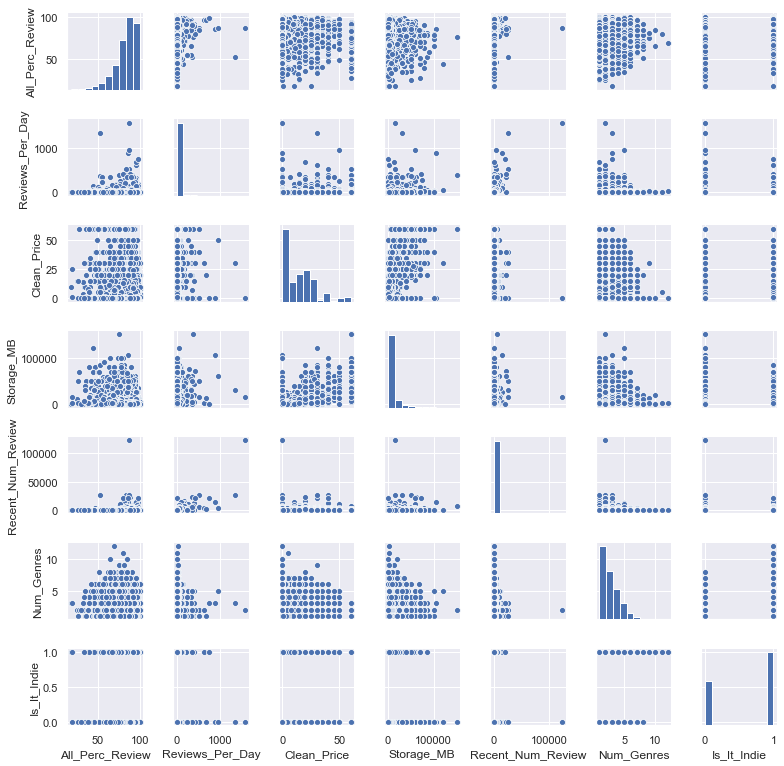

In [8]:
# Create a pair plot to examine correlations
sns.pairplot(df, height = 1.5, aspect = 1);

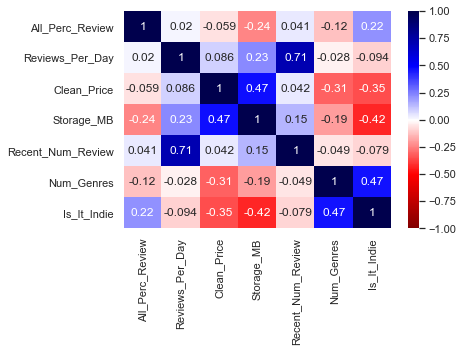

In [9]:
# Create a heat map to quantify correlations
sns.heatmap(df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1);

Perform linear regression. Removing 'Recent_Num_Reviews' changes the R2 value by the **smallest** amount. Removing 'Num_Genres' changes the R2 value by the **largest** amount.

Statsmodel is preerred here because it gives a detailed summary report.

In [10]:
# Define the model
lm = smf.ols('All_Perc_Review ~ Reviews_Per_Day + Clean_Price + \
                                Storage_MB + Recent_Num_Review + \
                                Num_Genres + Is_It_Indie', data=df)

# Fit the model
fit_overview = lm.fit()

# Print summary statistics of the model's performance
fit_overview.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        All_Perc_Review   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     82.43
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           1.90e-95
Time:                        17:11:46   Log-Likelihood:                -11143.
No. Observations:                2871   AIC:                         2.230e+04
Df Residuals:                    2864   BIC:                         2.234e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            85.8295      0.655    130.998      0.000      84.545      87.114
Reviews_Per_Day       0.0114      0.005      2.283      0.022       0.002       0.021
Clean_Price           0.0451      0.018      2.501      0.012       0.010       0.080
Storage_MB           -0.0002   1.93e-05    -10.265      0.000      -0.000      -0.000
Recent_Num_Review     0.0002      0.000      1.553      0.120   -4.66e-05       0.000
Num_Genres           -2.3767      0.171    -13.880      0.000      -2.712      -2.041
Is_It_Indie           7.3729      0.557     13.243      0.000       6.281       8.465
==============================================================================
Omnibus:                      747.547   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1921.380
Skew:                          -1.397   Prob(JB):                         0.00
Kurtosis:                       5.873   Cond. No.                     5.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

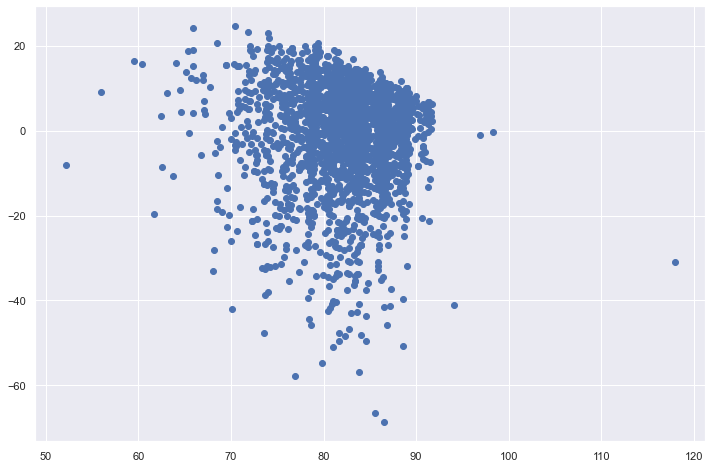

In [11]:
# Residual plot with 6 features
plt.figure(figsize=(12,8))
plt.scatter(fit_overview.predict(), fit_overview.resid);

Use sklearn to quickly check the R^2 values when removing individual features. This is a good way to check which features are significant/insignificant; however, the correlation heatmap should be taken into account as well.

In [12]:
# Create an empty model
lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:, 1:]

# Choose the response variable(s)
y = df.iloc[:, 0]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.1472638913786819

In [13]:
# Remove feature 'Recent_Num_Review'; results indicate smallest contribution
X = df.iloc[:, [1, 2, 3, 5, 6]]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.14654537195527473

In [14]:
# Remove feature 'Num_Genres'; results indicate largest contribution
X = df.iloc[:, [1, 2, 3, 4, 6]]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.08989978496647033

In [15]:
# Remove feature 'Is_It_Indie'; results indicate largest contribution
X = df.iloc[:, [1, 2, 3, 4, 5]]

# Fit the model to the full dataset
lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr.score(X,y)

0.09504336142037317

## Train/Test Split and Feature Scaling

The next step is start training/validation our model, but a pre-requisite of that is to apply standard_scalar for feature scaling to our dataset so that we have interpretable beta coefficients.

Index from dataframe for features is:
* [1] Reviews_Per_Day
* [2] Clean_Price
* [3] Storage_MB
* [4] Recent_Num_Review (Remove Here)
* [5] Num_Genres
* [6] Is_It_Indie (Remove Here)

**It should be firmly noted that X will only have _four features_ moving forward in this notebook.** A quick check using X.info() shows the columns and datatypes. We will then designate our X (feaures) and y (target variable).

In [16]:
# Recall that we're referring to our previous assignment of X (5 features)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 0 to 19555
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Reviews_Per_Day    2871 non-null   float64
 1   Clean_Price        2871 non-null   float64
 2   Storage_MB         2871 non-null   float64
 3   Recent_Num_Review  2871 non-null   float64
 4   Num_Genres         2871 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 214.6 KB


In [17]:
# Assigns features (X) and target variable (y)
X, y = df.drop('All_Perc_Review',axis=1), df['All_Perc_Review']
X = df.iloc[:, [1, 2, 3, 5]]

In [18]:
# We can see here what our X is defined as.
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 0 to 19555
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviews_Per_Day  2871 non-null   float64
 1   Clean_Price      2871 non-null   float64
 2   Storage_MB       2871 non-null   float64
 3   Num_Genres       2871 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 192.1 KB


In [19]:
# Do another quick OLS check to see what our R^2 is

# Define the model
lm = smf.ols('All_Perc_Review ~ Reviews_Per_Day + Clean_Price + \
                                Storage_MB + Num_Genres', data=df)

# Fit the model
fit_overview = lm.fit()

# Print summary statistics of the model's performance
fit_overview.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        All_Perc_Review   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     74.79
Date:                Thu, 16 Jul 2020   Prob (F-statistic):           2.23e-60
Time:                        17:11:46   Log-Likelihood:                -11230.
No. Observations:                2871   AIC:                         2.247e+04
Df Residuals:                    2866   BIC:                         2.250e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          88.6863      0.638    139.082      0.000      87.436      89.937
Reviews_Per_Day     0.0166      0.004      4.583      0.000       0.010       0.024
Clean_Price         0.0233      0.018      1.264      0.206      -0.013       0.060
Storage_MB         -0.0003   1.89e-05    -14.729      0.000      -0.000      -0.000
Num_Genres         -1.4611      0.161     -9.089      0.000      -1.776      -1.146
==============================================================================
Omnibus:                      791.031   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2067.765
Skew:                          -1.473   Prob(JB):                         0.00
Kurtosis:                       5.933   Cond. No.                     4.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

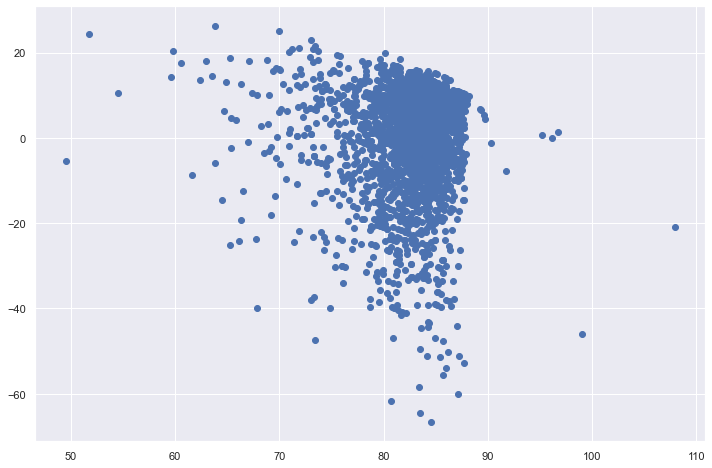

In [20]:
# Residual plot with 4 features
plt.figure(figsize=(12,8))
plt.scatter(fit_overview.predict(), fit_overview.resid);

**We will now split our datset. First, we will split it by 20% for testing at the end. Then, we will do another 20% split for validation (which will leave 60% for validation). Also scale the training, validation, and test set so that we can interpret our data.**

In [21]:
# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [22]:
# Using train_test_split and random state 42, let's further partition X, y into datasets
# X_train, y_train (60% of original) and X_val, y_val (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [23]:
# Feature scaling for train, val, and test so that we can run ridge/lasso model on each
# Also useful to check 'normal' linear regression with these scaled features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1836 entries, 6244 to 3270
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviews_Per_Day  1836 non-null   float64
 1   Clean_Price      1836 non-null   float64
 2   Storage_MB       1836 non-null   float64
 3   Num_Genres       1836 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 71.7 KB


## Modeling with Four Remaining Features

Remaining features include: **Reviews/Day, Price, Storage, and Quantity of Genres**.

Ridge:
* Pro: great for smoothly handling multicollinearity, very nice when working with sparse features
* Con: will never fully discard features

LASSO:
* Pro: great for trimming features and focusing interpretation on a few key ones
* Con: risk of discarding features that are actually useful

We will first do a preliminary training/validation and examine the beta coefficients. There is no cross-validation here, so take these results with a grain of salt. This is mainly for exploratory purposes; cross-validation will be done afterwards.

In [25]:
#set up the 4 models we're choosing from:

# Linear regression
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

# Ridge regulation
lm_ridge = Ridge(alpha=0.03)
lm_ridge.fit(X_train_scaled, y_train)

# LASSO regulation
lm_lasso = Lasso(alpha=0.01)
lm_lasso.fit(X_train_scaled, y_train);

In [26]:
selected_columns = ['Reviews_Per_Day',
                    'Clean_Price',
                    'Storage_MB',
                    'Num_Genres']

list(zip(selected_columns, lm.coef_))

[('Reviews_Per_Day', 1.2778608398894589),
 ('Clean_Price', 0.3178557357078504),
 ('Storage_MB', -3.9734356272130986),
 ('Num_Genres', -2.472732621166906)]

## Validation and Examining Regulation

In [27]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_ridge.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_ridge.score(X_val_scaled, y_val):.3f}')

lm_lasso.fit(X_train_scaled, y_train)
print(f'LASSO Regression val R^2: {lm_lasso.score(X_val_scaled, y_val):.3f}')

#lm_poly.fit(X_train_poly, y_train)
#print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.110
Ridge Regression val R^2: 0.110
LASSO Regression val R^2: 0.110


## Testing

We can see that implementing our model on the test set is pretty bad. This is unfortunate, but not too suprising. We have not performed cross-validation and we also have very skewed data, which are both explanations for this result. Cross-validation and testing should result in closely aligned values (shown afterwards).

In [28]:
lm.fit(X, y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

lm_ridge.fit(X, y)
print(f'Ridge Regression test R^2: {lm_ridge.score(X_test, y_test):.3f}')

lm_lasso.fit(X, y)
print(f'LASSO Regression test R^2: {lm_lasso.score(X_test, y_test):.3f}')


Linear Regression test R^2: 0.032
Ridge Regression test R^2: 0.032
LASSO Regression test R^2: 0.032


## Cross-Validation (Rigorous Method)

The "rigorous method" paranthetical note is because I referenced the cross-validation notebook which shows two methods. For purposes of completing the project (heh, this was difficult at the time) we're sticking with this method. There's also a "less manual" method but they should both result in the same values.

To keep track of the notebook, let's also define a new smaller dataframe consisting of our target variable and four features: **df_smaller**. This notebook is getting pretty long and the project is due soon, so to avoid running into issues before the presentation date (by copy/pasting sections into a new notebook), we're going to have to settle with this.

In [29]:
from sklearn.model_selection import KFold

In [30]:
df_smaller = df[['All_Perc_Review',
         'Reviews_Per_Day', 'Clean_Price',
         'Storage_MB', 'Num_Genres']]

X, y = df_smaller.drop('All_Perc_Review',axis=1), df_smaller['All_Perc_Review']

# Hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# This helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [31]:
# Run the CV (Cross-Validation)

kf = KFold(n_splits=5, shuffle=True, random_state = 10)

# Collect the validation results for all models
cv_lm_r2s, cv_lm_ridge_r2s, cv_lm_lasso_r2s = [], [], []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #scalar feature
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    #ridge
    lm_ridge = Ridge(alpha = 0.03)
    
    lm_ridge.fit(X_train_scaled, y_train)
    cv_lm_ridge_r2s.append(lm_ridge.score(X_val_scaled, y_val))
                         
    #LASSO with feature scaling
    lm_lasso = Lasso(alpha = 0.01)
    
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_ridge_r2s)
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_ridge_r2s):.3f} +- {np.std(cv_lm_ridge_r2s):.3f}')
print(f'LASSO mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')

Simple regression scores:  [0.07553031755691464, 0.09233339479657521, 0.11017477066033521, 0.10954708776679434, 0.07267328164598674]
Ridge scores:  [0.07553071895684627, 0.09233375248892028, 0.11017438836345983, 0.10954678690614117, 0.07267408775169937]
Lasso scores:  [0.07563185599634736, 0.09240289725396134, 0.11005852530813176, 0.1093702334635257, 0.07283021473846507] 

Simple mean cv r^2: 0.092 +- 0.016
Ridge mean cv r^2: 0.092 +- 0.016
LASSO mean cv r^2: 0.092 +- 0.016


## Test from Cross-Validation (Rigorous Method)

Let's apply our cross-validated method to our test set now.

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [33]:
lm = LinearRegression()
lm.fit(X_scaled,y)
print(f'Simple Regression test R^2: {lm.score(X_test_scaled, y_test):.3f}')

Simple Regression test R^2: 0.073


In [34]:
lm_ridge = Ridge(alpha=0.03)
lm_ridge.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_ridge.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.073


In [35]:
lm_lasso = Lasso(alpha=0.01)
lm_lasso.fit(X_scaled,y)
print(f'LASSO Regression test R^2: {lm_lasso.score(X_test_scaled, y_test):.3f}')

LASSO Regression test R^2: 0.073


## Find Alpha Using Grid Search

Take note that we've been using linear regression with regularization, but we haven't found an optimal alpha value yet. We used the default (alpha=1) but regularization requires finding the ideal strength parameter (alpha or lambda, both terms are used in the lecture).

We'll use a grid search method to find the optimal alpha value for ridge and lasso independently. After we find it, we'll manually go back to our regularization methods and insert these values.

* For ridge: alpha = 0.03
* For LASSO: alpha = 0.01

There's not a change in our R^2 values using regularization. Remember that **regularization is used to reduce overfitting**, but we don't have overfitting issues. We actually have issues with _having a good fit at all_. Still, it's a good sanity check that's in agreement with our expectations.

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [37]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [38]:
grid_ridge = GridSearchCV(estimator=Ridge(normalize=True),  # must be an sklearn estimator
                    param_grid={'alpha': np.arange(0.01, 2.01, 0.01)},
                    cv=kfold,
                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
                    return_train_score=True)

In [39]:
grid_ridge.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Ridge(normalize=True),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0....
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99, 2.  ])},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [40]:
# With the `grid`, we need to actively *pick* the model we'd like to return.
grid_ridge.best_estimator_

Ridge(alpha=0.03, normalize=True)

In [41]:
grid_lasso = GridSearchCV(estimator=Lasso(normalize=True),  # must be an sklearn estimator
                    param_grid={'alpha': np.arange(0.01, 2.01, 0.01)},
                    cv=kfold,
                    scoring=make_scorer(mean_squared_error, greater_is_better=False),
                    return_train_score=True)

In [42]:
grid_lasso.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Lasso(normalize=True),
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0....
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52, 1.53, 1.54,
       1.55, 1.56, 1.57, 1.58, 1.59, 1.6 , 1.61, 1.62, 1.63, 1.64, 1.65,
       1.66, 1.67, 1.68, 1.69, 1.7 , 1.71, 1.72, 1.73, 1.74, 1.75, 1.76,
       1.77, 1.78, 1.79, 1.8 , 1.81, 1.82, 1.83, 1.84, 1.85, 1.86, 1.87,
       1.88, 1.89, 1.9 , 1.91, 1.92, 1.93, 1.94, 1.95, 1.96, 1.97, 1.98,
       1.99, 2.  ])},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [43]:
# With the `grid`, we need to actively *pick* the model we'd like to return.
grid_lasso.best_estimator_

Lasso(alpha=0.01, normalize=True)

## Beta Coefficients

Let's take a look at our beta coefficients from our modeling. It should be pretty consistent with or without regularizatin, which we observe. Remember that these coefficients are in the formula:

y = beta * X1 + beta * X2 + beta * X3 + ...

In [44]:
selected_columns = ['Reviews_Per_Day',
                    'Clean_Price',
                    'Storage_MB',
                    'Num_Genres']

In [45]:
list(zip(selected_columns, lm.coef_))

[('Reviews_Per_Day', 1.086296688403962),
 ('Clean_Price', 0.46479310382647965),
 ('Storage_MB', -3.9593267629763176),
 ('Num_Genres', -2.3171578191899758)]

In [46]:
list(zip(selected_columns, lm_ridge.coef_))

[('Reviews_Per_Day', 1.0862677697986773),
 ('Clean_Price', 0.46476274721963395),
 ('Storage_MB', -3.959247065830099),
 ('Num_Genres', -2.3171223792259927)]

In [47]:
list(zip(selected_columns, lm_lasso.coef_))

[('Reviews_Per_Day', 1.0727576665734855),
 ('Clean_Price', 0.44782618901254223),
 ('Storage_MB', -3.936460191636479),
 ('Num_Genres', -2.3083814735724903)]

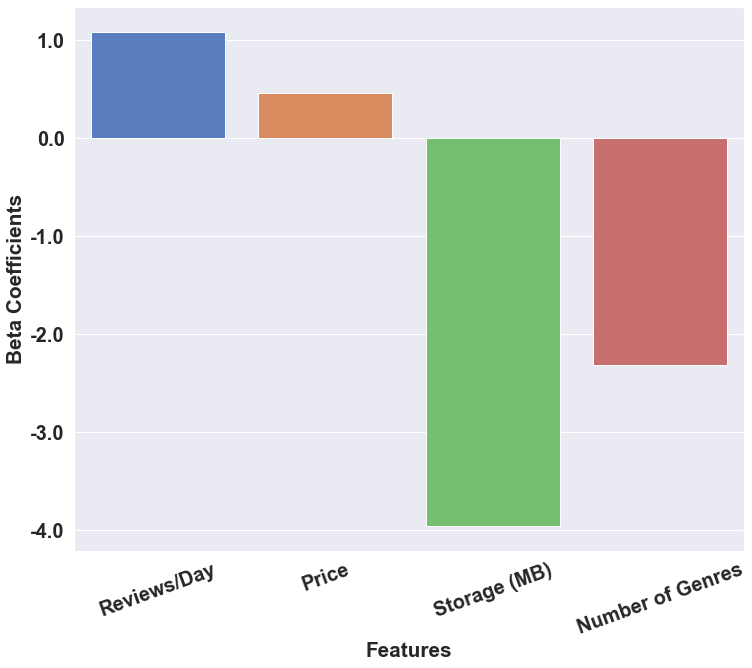

In [48]:
# Plot of beta coefficients

plt.figure(figsize=[12, 10])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

# Divide by 1e6 for millions, divide by [7 days x 3 weeks x 3 months]
ax1 = sns.barplot(x = ['Reviews/Day', 'Price', 'Storage (MB)', 'Number of Genres'],
                  y = ['1.086', '0.464', '-3.959', '-2.317'],
                  palette = "muted",)
#ax1.x_labels(['Reviews/Day', 'Price', 'Storage (MB)', '# of Genres'])

ax1.set_xticklabels(['Reviews/Day', 'Price', 'Storage (MB)', 'Number of Genres'], size = 20)
ax1.set_yticklabels(ax1.get_yticks(), size = 20)

ax1.set_xlabel('Features', fontdict=font, fontsize='xx-large')
ax1.set_ylabel('Beta Coefficients', fontdict=font, fontsize='xx-large')

plt.xticks(rotation=20)

#plt.title('Beta Coefficient', fontdict=font, fontsize='xx-large');


plt.savefig('beta_coefficients.png', dpi = 300)

## Mean Absolute Error (MAE)

In [49]:
test_set_pred_lm = lm.predict(X_test_scaled)
test_set_pred_lm_ridge = lm_ridge.predict(X_test_scaled)
test_set_pred_lm_lasso = lm_lasso.predict(X_test_scaled)

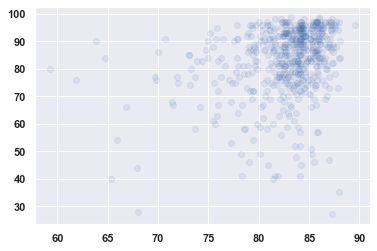

In [50]:
plt.scatter(test_set_pred_lm, y_test, alpha=.1)
#plt.plot(np.linspace(0,100,1000), np.linspace(0,100,1000))

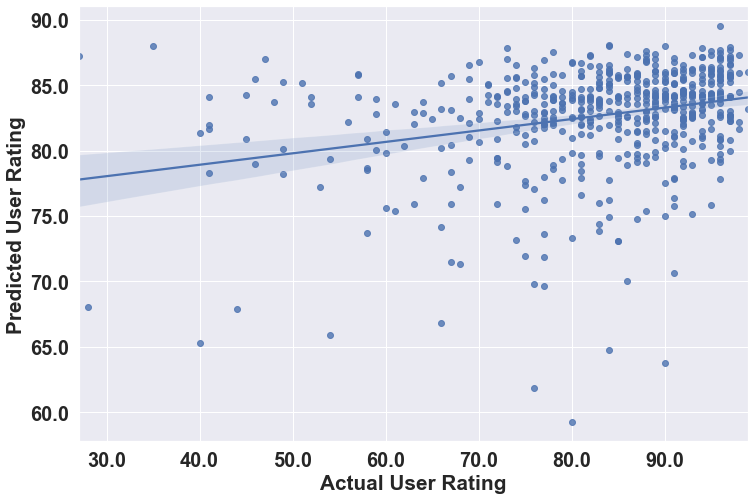

In [51]:
plt.figure(figsize=[12, 8])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

ax1 = sns.regplot(x = y_test,
                 y = test_set_pred_lm)

ax1.set_xticklabels(ax1.get_xticks(), size = 20)
ax1.set_yticklabels(ax1.get_yticks(), size = 20)

ax1.set_xlabel('Actual User Rating', fontdict=font, fontsize='xx-large')
ax1.set_ylabel('Predicted User Rating', fontdict=font, fontsize='xx-large')

plt.savefig('predicted_vs_target.png', dpi = 300)

In [52]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [53]:
print('mae for lm:')
mae(y_test, test_set_pred_lm)

mae for lm:


9.162392081470939

In [54]:
print('mae for lm ridge:')
mae(y_test, test_set_pred_lm_ridge)

mae for lm ridge:


9.162391903580527

In [55]:
print('mae for lm lasso:')
mae(y_test, test_set_pred_lm_lasso)

mae for lm lasso:


9.161771672283447